In [6]:
import re
from collections import defaultdict
import matplotlib.pyplot as plt
import os
import numpy as np
import powerlaw
import math
from sklearn import linear_model
from scipy.stats import norm
np.set_printoptions(suppress=True)


### All functions

In [7]:
def load_flle(filename):
    x = []
    with open(filename) as f:
        line = f.readline()
        line = line.strip('\n')
    return line

def dirlist(path, files): #找到指定資料夾下所有資料
    filelist = os.listdir(path)

    for filename in filelist:
        filepath = os.path.join(path, filename)
        if os.path.isdir(filepath):
            dirlist(filepath, files)
        else:
            files.append(filepath)
    return files

def load_train_files(path):
    x = []
    y = []
    list = os.listdir(path)
    for i in range(0, len(list)):
        path2 = os.path.join(path, list[i])
        if os.path.isfile(path2):
            x.append(load_flle(path2))
            y.append(0)
    return x, y


def load_attack_files(path, x, y, attack_type):
    total = 0
    for i in range(1,11):
        files = dirlist(path + attack_type +"_" + str(i), [])
        total = total + len(files)
        for file in files:
            x.append(load_flle(file))
            y.append(1)
    print(attack_type + " data: " + str(total))
    return x, y

def get_increasing_array(length): #拿到x軸的數列 : [1,2,3,.....,N]
    arr = np.zeros(length)
    for i in range(length):
        arr[i] = i
    return arr

def find_one(arr): #找到陣列第一個出現1的index
    for i in range(len(arr)):
        if arr[i] == 1:
            break
    return i

def indent(arr): #壓縮連續重複呼叫的system call number成一個
    last = -1
    rt_arr = np.zeros(1)
    for i in range(len(arr)):
        if arr[i] != last:
            rt_arr = np.append(rt_arr, arr[i])
            last = arr[i]
            
    return rt_arr[1:]

def systemcall_classify(query):
    class_outcome = np.zeros((1,12))
    query = query.strip().split(' ')
    for i in query:
        if int(i) in Machine_dependent:
            class_outcome[0][0] += 1
        elif int(i) in Filesystem:
            class_outcome[0][1] += 1
        elif int(i) in Linux_Kernel:
            class_outcome[0][2] += 1
        elif int(i) in Scheduling:
            class_outcome[0][3] += 1
        elif int(i) in Signals:
            class_outcome[0][4] += 1
        elif int(i) in Systems:
            class_outcome[0][5] += 1
        elif int(i) in Time:
            class_outcome[0][6] += 1
        elif int(i) in Kernel_Process:
            class_outcome[0][7] += 1
        elif int(i) in UID:
            class_outcome[0][8] += 1
        elif int(i) in Memory_Management:
            class_outcome[0][9] += 1
        elif int(i) in Swapfile:
            class_outcome[0][10] += 1
        elif int(i) in Socket:
            class_outcome[0][11] += 1
    return class_outcome

def systemcall_transfer(query):
    query = query.strip().split(' ')
    for i in range(len(query)):
        if int(query[i]) in Machine_dependent:
            query[i] = '1'
        elif int(query[i]) in Filesystem:
            query[i] = '2'
        elif int(query[2]) in Linux_Kernel:
            query[i] = '3'
        elif int(query[i]) in Scheduling:
            query[i] = '4'
        elif int(query[i]) in Signals:
            query[i] = '5'
        elif int(query[i]) in Systems:
            query[i] = '6'
        elif int(query[i]) in Time:
            query[i] = '7'
        elif int(query[i]) in Kernel_Process:
            query[i] = '8'
        elif int(query[i]) in UID:
            query[i] = '9'
        elif int(query[i]) in Memory_Management:
            query[i] = '10'
        elif int(query[i]) in Swapfile:
            query[i] = '11'
        elif int(query[i]) in Socket:
            query[i] = '12'
        else:
            query[i] = '0' #self-defined system call
    return query

def log_and_fit(X,Y):
    X = np.log10(X)  
    Y = np.log10(Y) 
    X2 = []
    Y2 = []
    for xi ,yi in zip(X,Y):
        X2.append([float(xi)])
        Y2.append(float(yi))

    regr = linear_model.LinearRegression()
    regr.fit(X2, Y2)
    #y' = Gamma * X' + A
    print('Gamma: ', regr.coef_)
    print("A: ",regr.intercept_)
    # The mean square error
    print("error: %.8f" % np.mean((regr.predict(X2) - Y2) ** 2))  # 残差平方

    plt.title("Log Data")
    plt.scatter(X2, Y2,  color='blue', s=10)
    plt.plot(X2, regr.predict(X2), color='red',linewidth=3)

    #plt.xticks([]) #關閉X軸
    #plt.yticks([]) #關閉y軸
    plt.show()
    
def load_new_attack_files(path, x, y, attack_type):
    # return x:length of each attack file
    total = 0
    files = dirlist(path + attack_type, [])
    total = total + len(files)
    for file in files:
        x.append(load_flle(file))
        y.append(1)
    print(attack_type + " data: " + str(total))
    return x, y

def calculate_attack_syscall_avg(attack_type):
    x_orig = []
    x_extend = []
    y_orig = []
    y_extend = []

    x_orig, y_orig = load_attack_files("ADFA-LD/Attack_Data_Master/", x_orig, y_orig, attack_type)
    fileIndex = 0 # attack count
    totalLen = 0
    x_avglen = 0
    for d in x_orig:
        d = d.rstrip()
        fileIndex+=1
        if (fileIndex == 1): print(fileIndex, ": ", d, "\nThe syscall length of this attack file: ", len(d.split(' ')),  "\n")
        totalLen += len(d.split(' '))

    x_avglen = totalLen / len(x_orig)
    print("Avg", attack_type, "system call length:", x_avglen, "\n")
    return x_avglen


### Sampling attack data

In [8]:
# sampling the attack sequence data
def sampling(attack_type):
    x_orig = []
    y_orig = []
    x_orig, y_orig = load_attack_files("ADFA-LD/Attack_Data_Master/", x_orig, y_orig, attack_type)
    syscalls = []
    
    dic_addusr = defaultdict(lambda: 0)
    n = 3 # 3-gram
      
    ## one attack data n-gram
    for d in x_orig:
        data = d.strip().split(' ')
        for i in range(len(data) - n + 1):
            index = ' '.join(data[i:i+n])
            dic_addusr[index] = dic_addusr[index] + 1
    out = sorted(dic_addusr.items(), key=lambda kv: kv[1], reverse=True)
    print( "3-gram:", list(out[1][0].strip().split(' ')), list(out[1][0].strip().split(' ')) )
    
    ## compare to the avg.
    avg = calculate_attack_syscall_avg(attack_type)
    
    
    print("========== starting sampling data ==========\n")
    
    new_syscall = []
    i=0 # file index
    j=0 # syscall index
    m=0 # new file index
    for d in x_orig:
        i+=1
        print("==========", attack_type, i, "==========\n")
        syscalls = d.strip().split(' ')
        for call in syscalls:
            j+=1
            for k in range(0, 100):
                tmp = (list(out[k][0].strip().split(' ')))
                if ( call == tmp[0] ):
                    # deal with sampling
                    # print("file:", i, ", call index:", j, ", find in: ", k, ", the syscall is: ", call, ", the 3-gram: ", tmp)
                    new_syscall.extend( list(out[k][0].split(' ')) )
                    break
                if ( len(new_syscall) > avg ):
                    m+=1
                    # output new attack data as txt
                    print(len(new_syscall), new_syscall, "\n")
                    with open('ADFA-LD/new_data/{0}/{1}_{2}_{3}.txt'.format(attack_type, attack_type, i, m), 'w') as f:
                        for item in new_syscall:
                            f.write("%s " % item)
                    new_syscall = []
        m=0
        j=0

### sampling data

In [9]:
sampling("Adduser")
sampling("Hydra_FTP")
sampling("Hydra_SSH")
sampling("Java_Meterpreter")
sampling("Meterpreter")
sampling("Web_Shell")

Adduser data: 91
3-gram: ['162', '162', '162'] ['162', '162', '162']
Adduser data: 91
1 :  3 3 168 168 168 146 168 168 168 265 3 265 168 168 265 168 168 168 265 265 3 168 168 265 168 146 168 265 168 168 168 146 168 168 265 168 146 168 265 265 3 168 168 3 3 168 3 3 265 3 168 265 168 3 168 168 168 168 3 168 146 168 265 168 78 265 168 168 3 265 78 265 168 168 168 265 168 19 265 265 168 265 168 4 3 168 265 168 265 265 3 78 265 3 168 168 146 168 146 3 168 146 168 168 265 265 168 168 168 168 168 168 168 146 265 3 3 168 168 265 168 168 168 3 265 168 265 168 146 3 265 146 146 168 168 146 168 146 3 146 168 168 168 168 168 168 168 3 168 168 146 168 265 3 168 146 3 168 265 168 168 146 3 168 265 168 168 168 168 146 168 265 168 168 168 146 168 168 168 265 265 3 168 168 265 168 168 168 168 168 168 168 168 265 168 168 168 265 3 168 168 146 168 265 3 146 168 168 168 265 19 168 168 168 265 168 265 3 168 265 168 168 146 265 168 146 3 168 3 3 265 168 168 265 265 265 162 168 3 78 265 78 4 19 19 19 4 19 19

FileNotFoundError: [Errno 2] No such file or directory: 'ADFA-LD/new_data/Adduser/Adduser_1_1.txt'

## read data

In [10]:
attack_type = ['Adduser', 'Hydra_FTP', 'Hydra_SSH', 'Java_Meterpreter', 'Meterpreter', 'Web_Shell']

xa = []
ya = []
for attack in attack_type:
    xa, ya = load_attack_files("ADFA-LD/Attack_Data_Master/", xa, ya, attack)

xt, yt = load_train_files("ADFA-LD/Training_Data_Master/")  
xv, yv = load_train_files("ADFA-LD/Validation_Data_Master/")  

x_addusr = []
y_addusr = []
x_addusr, y_addusr = load_attack_files("ADFA-LD/Attack_Data_Master/", x_addusr, y_addusr, 'Adduser')

x_ftp = []
y_ftp = []
x_ftp, y_ftp = load_attack_files("ADFA-LD/Attack_Data_Master/", x_ftp, y_ftp, 'Hydra_FTP')

x_ssh = []
y_ssh = []
x_ssh, y_ssh = load_attack_files("ADFA-LD/Attack_Data_Master/", x_ssh, y_ssh, 'Hydra_SSH')

x_java = []
y_java = []
x_java, y_java = load_attack_files("ADFA-LD/Attack_Data_Master/", x_java, y_java, 'Java_Meterpreter')

x_met = []
y_met = []
x_met, y_met = load_attack_files("ADFA-LD/Attack_Data_Master/", x_met, y_met, 'Meterpreter')

x_web = []
y_web = []
x_web, y_web = load_attack_files("ADFA-LD/Attack_Data_Master/", x_web, y_web, 'Web_Shell')




Adduser data: 91
Hydra_FTP data: 162
Hydra_SSH data: 176
Java_Meterpreter data: 124
Meterpreter data: 75
Web_Shell data: 118
Adduser data: 91
Hydra_FTP data: 162
Hydra_SSH data: 176
Java_Meterpreter data: 124
Meterpreter data: 75
Web_Shell data: 118


### Normal n = 1

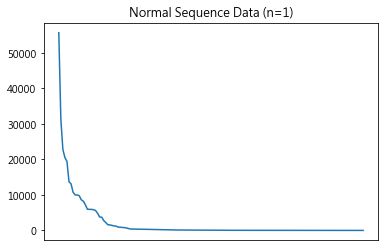

('3', '4', '6', '5', '195')
(55664, 31342, 22782, 20503, 19414)
Gamma:  [-2.78510005]
A:  6.763820168881087
error: 0.15741804


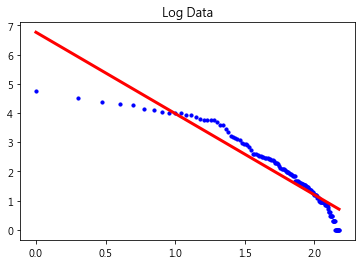

In [11]:
n = 1
dic_normal = defaultdict(lambda: 0)
for d in xt:
    data = d.strip().split(' ')
    #data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_normal[index] = dic_normal[index] + 1

lists = sorted(dic_normal.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists) # unpack a list of pairs into two tuples

plt.title("Normal Sequence Data (n=1)")
plt.plot(px, py)
plt.xticks([]) #關閉X軸
plt.show()
print(px[:5])
print(py[:5])

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### Normal n = 2

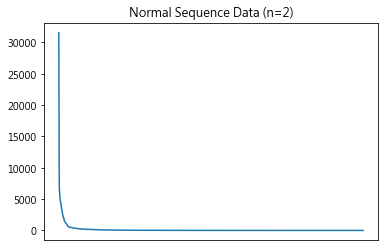

('3 3', '4 4', '195 195', '240 240', '197 192')
(31531, 22334, 9163, 8999, 6716)
Gamma:  [-1.99643313]
A:  6.70004890695763
error: 0.03847234


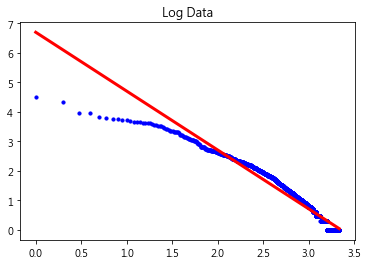

In [12]:
n = 2
dic_normal = defaultdict(lambda: 0)
for d in xt:
    data = d.strip().split(' ')
    #data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_normal[index] = dic_normal[index] + 1

lists = sorted(dic_normal.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists) # unpack a list of pairs into two tuples
plt.title("Normal Sequence Data (n=2)")
plt.plot(px, py)
plt.xticks([]) #關閉X軸
plt.show()
print(px[:5])
print(py[:5])

ax = get_increasing_array(len(py)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### Normal n = 3

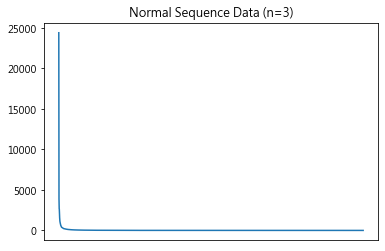

('3 3 3', '4 4 4', '195 195 195', '240 240 240', '180 180 180')
(24377, 19206, 6560, 5802, 5305)
Gamma:  [-1.46100414]
A:  5.760790534996109
error: 0.01035605


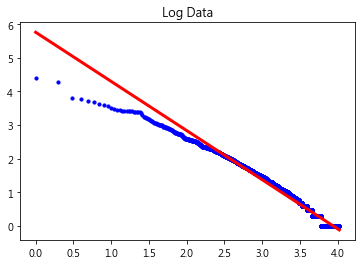

In [13]:
n = 3
dic_normal = defaultdict(lambda: 0)
for d in xt:
    data = d.strip().split(' ')
    #data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_normal[index] = dic_normal[index] + 1

lists = sorted(dic_normal.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists) # unpack a list of pairs into two tuples
plt.title("Normal Sequence Data (n=3)")
plt.plot(px, py)
plt.xticks([]) #關閉X軸
plt.show()
print(px[:5])
print(py[:5])

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### Load new attack data

In [14]:
x_addusr = []
y_addusr = []
x_addusr, y_addusr = load_new_attack_files("ADFA-LD/new_data/", x_addusr, y_addusr, 'Adduser')

x_ftp = []
y_ftp = []
x_ftp, y_ftp = load_new_attack_files("ADFA-LD/new_data/", x_ftp, y_ftp, 'Hydra_FTP')

x_ssh = []
y_ssh = []
x_ssh, y_ssh = load_new_attack_files("ADFA-LD/new_data/", x_ssh, y_ssh, 'Hydra_SSH')

pwd = x_ftp + x_ssh
print(len(pwd), "=", len(x_ftp), "+", len(x_ssh), n)

x_java = []
y_java = []
x_java, y_java = load_new_attack_files("ADFA-LD/new_data/", x_java, y_java, 'Java_Meterpreter')

x_met = []
y_met = []
x_met, y_met = load_new_attack_files("ADFA-LD/new_data/", x_met, y_met, 'Meterpreter')

dll = x_java + x_met
print(len(dll), "=", len(x_java), "+", len(x_met), n)

x_web = []
y_web = []
x_web, y_web = load_new_attack_files("ADFA-LD/new_data/", x_web, y_web, 'Web_Shell')


FileNotFoundError: [Errno 2] No such file or directory: 'ADFA-LD/new_data/Adduser'

### Password Brute-force attack

### n = 2

In [ ]:
dic_xa = defaultdict(lambda: 0)
n = 2

for d in pwd:
    data = d.strip().split(' ')
    data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_xa[index] = dic_xa[index] + 1

lists = sorted(dic_xa.items(), key=lambda kv: kv[1], reverse=True)

for i in lists[0:5]:
    print(i)
    pass
px, py = zip(*lists) 
print('攻擊序列中出現的system call種類 : ',len(lists))
x_axis = get_increasing_array(len(lists)+1)
plt.plot(x_axis[1:], py)
plt.show()

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)


### n = 3

In [ ]:
dic_xa = defaultdict(lambda: 0)
n = 3

for d in pwd:
    data = d.strip().split(' ')
    data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_xa[index] = dic_xa[index] + 1

lists = sorted(dic_xa.items(), key=lambda kv: kv[1], reverse=True)

for i in lists[0:5]:
    print(i)
    pass
px, py = zip(*lists) 
print('攻擊序列中出現的system call種類 : ',len(lists))
x_axis = get_increasing_array(len(lists)+1)
plt.plot(x_axis[1:], py)
plt.show()

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)


### Client exploit

### n = 2

In [ ]:
n = 2
dic_xa = defaultdict(lambda: 0)
x_addusr = []
y_addusr = []
x_addusr, y_addusr = load_new_attack_files("ADFA-LD/new_data/", x_addusr, y_addusr, 'Adduser')

for d in x_addusr:
    data = d.strip().split(' ')
    data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_xa[index] = dic_xa[index] + 1

lists = sorted(dic_xa.items(), key=lambda kv: kv[1], reverse=True)
for i in lists[0:5]:
    print(i)
    pass


px, py = zip(*lists) 
print('攻擊序列中出現的system call種類 : ',len(lists))
x_axis = get_increasing_array(len(lists)+1)
plt.plot(x_axis[1:], py)
plt.show()

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### n = 3

In [ ]:
n = 3
dic_xa = defaultdict(lambda: 0)
x_addusr = []
y_addusr = []
x_addusr, y_addusr = load_new_attack_files("ADFA-LD/new_data/", x_addusr, y_addusr, 'Adduser')

for d in x_addusr:
    data = d.strip().split(' ')
    data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_xa[index] = dic_xa[index] + 1

lists = sorted(dic_xa.items(), key=lambda kv: kv[1], reverse=True)
for i in lists[0:5]:
    print(i)
    pass


px, py = zip(*lists) 
print('攻擊序列中出現的system call種類 : ',len(lists))
x_axis = get_increasing_array(len(lists)+1)
plt.plot(x_axis[1:], py)
plt.show()

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### DLL injection

### n = 2

In [15]:
n = 2
dic_xa = defaultdict(lambda: 0)

for d in dll:
    data = d.strip().split(' ')
    data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_xa[index] = dic_xa[index] + 1

lists = sorted(dic_xa.items(), key=lambda kv: kv[1], reverse=True)
for i in lists[0:5]:
    print(i)
    pass

px, py = zip(*lists) 
print('攻擊序列中出現的system call種類 : ',len(lists))
x_axis = get_increasing_array(len(lists)+1)
plt.plot(x_axis[1:], py)
plt.show()

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

NameError: name 'dll' is not defined

### n = 3

In [ ]:
n = 3
dic_xa = defaultdict(lambda: 0)

for d in dll:
    data = d.strip().split(' ')
    data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_xa[index] = dic_xa[index] + 1

lists = sorted(dic_xa.items(), key=lambda kv: kv[1], reverse=True)
for i in lists[0:5]:
    print(i)
    pass

px, py = zip(*lists) 
print('攻擊序列中出現的system call種類 : ',len(lists))
x_axis = get_increasing_array(len(lists)+1)
plt.plot(x_axis[1:], py)
plt.show()

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### Remote File Inclusion

### n = 2

In [ ]:
n = 2
dic_xa = defaultdict(lambda: 0)

for d in x_web:
    data = d.strip().split(' ')
    data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_xa[index] = dic_xa[index] + 1

lists = sorted(dic_xa.items(), key=lambda kv: kv[1], reverse=True)
for i in lists[0:5]:
    print(i)
    pass

px, py = zip(*lists) 
print('攻擊序列中出現的system call種類 : ',len(lists))
x_axis = get_increasing_array(len(lists)+1)
plt.plot(x_axis[1:], py)
plt.show()

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### n = 3

In [ ]:
n = 3
dic_xa = defaultdict(lambda: 0)

for d in x_web:
    data = d.strip().split(' ')
    data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_xa[index] = dic_xa[index] + 1

lists = sorted(dic_xa.items(), key=lambda kv: kv[1], reverse=True)
for i in lists[0:5]:
    print(i)
    pass

px, py = zip(*lists) 
print('攻擊序列中出現的system call種類 : ',len(lists))
x_axis = get_increasing_array(len(lists)+1)
plt.plot(x_axis[1:], py)
plt.show()

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### classification

In [16]:
Machine_dependent = [101,110,123,2,11,120,190,243,244,26,67,72,119,173,179,186,42,59,82,90,109,117,192,113,166]
#print(len(Machine_dependent))
Filesystem = [245,246,247,248,249,36,118,134,148,183,253,254,255,256,86,41,55,63,221,135,54,143,9,10,14,38,39,40,\
              83,21,22,52,217,169,5,6,8,12,15,30,33,61,92,93,94,99,100,111,133,193,194,198,207,212,268,269,131,89,\
              141,220,3,4,19,140,145,146,180,181,187,239,142,168,18,28,84,85,106,107,108,195,196,197,62,226,227,228,\
              229,230,231,232,233,234,235,236,237]
#print(len(Filesystem))
Linux_Kernel = [51,184,185,136,1,7,114,252,258,240,104,105,128,129,162,259,260,261,262,263,264,265,266,267,103]
#print(len(Linux_Kernel))
Scheduling = [34,154,155,156,157,158,159,160,161,241,242]
#print(len(Scheduling))
Signals = [0,29,37,48,68,69,73,126,174,175,176,177,178,238,270]
#print(len(Signals))
Systems = [43,57,60,65,66,74,75,76,77,88,96,97,121,122,132,147,172,191,203,204,205,206,208,209,210,211,213,214,215,\
           216,149]
#print(len(Systems))
Time = [13,25,78,79,124]
#print(len(Time))
Kernel_Process = [20,27,64,116,199,200,201,202,224]
#print(len(Kernel_Process))
UID = [16,23,24,46,47,49,50,70,71,80,81,95,138,139,164,165,170,171,182]
#print(len(UID))
Memory_Management = [250,225,257,219,218,150,151,152,153,45,91,125,163,144]
#print(len(Memory_Management))
Swapfile = [87,115]
#print(len(Swapfile))
Socket = [102]
#print(len(Socket))

print('total: ',len(Machine_dependent) + len(Filesystem) + len(Linux_Kernel) \
      + len(Scheduling) + len(Signals) + len(Systems) + len(Time) + len(Kernel_Process) \
      + len(UID) + len(Memory_Management) + len(Swapfile) + len(Socket))

system_dic = {}
system_dic['Machine_dependent'] = 0
system_dic['Filesystem'] = 1
system_dic['Linux_Kernel'] = 2
system_dic['Scheduling'] = 3
system_dic['Signals'] = 4
system_dic['Systems'] = 5
system_dic['Time'] = 6
system_dic['Kernel_Process'] = 7
system_dic['UID'] = 8
system_dic['Memory_Management'] = 9
system_dic['Swapfile'] = 10
system_dic['Socket'] = 11

print('Machine_dependent: ', 0)
print('Filesystem: ', 1)
print('Linux_Kernel: ', 2)
print('Scheduling: ', 3)
print('Signals: ', 4)
print('Systems: ', 5)
print('Time: ', 6)
print('Kernel_Process: ', 7)
print('UID: ', 8)
print('Memory_Management: ', 9)
print('Swapfile: ', 10)
print('Socket: ', 11)


total:  252
Machine_dependent:  0
Filesystem:  1
Linux_Kernel:  2
Scheduling:  3
Signals:  4
Systems:  5
Time:  6
Kernel_Process:  7
UID:  8
Memory_Management:  9
Swapfile:  10
Socket:  11


### statistical data

In [17]:
xt_call_distribution = np.zeros((1,12))
xa_call_distribution = np.zeros((1,12))

for d in xt:
    xt_call_distribution = np.concatenate((xt_call_distribution, systemcall_classify(d)), axis = 0)

print('train data下各類別system call總呼叫次數')
print(sum(xt_call_distribution[1:]))
print('train data下各類別system call單序列平均呼叫次數')
print(sum(xt_call_distribution[1:]) / len(xt) )    

for d in xv:
    xt_call_distribution = np.concatenate((xt_call_distribution, systemcall_classify(d)), axis = 0)

print('normal data下各類別system call總呼叫次數')
print(sum(xt_call_distribution[1:]))
print('normal data下各類別system call單序列平均呼叫次數')
print(sum(xt_call_distribution[1:]) / (len(xt) + len(xv)) )

for d in xa:
    xa_call_distribution = np.concatenate((xa_call_distribution, systemcall_classify(d)), axis = 0)
    
print('attack data下各類別system call總呼叫次數')
print(sum(xa_call_distribution[1:]))
print('attack data下各類別system call單序列平均呼叫次數')
print(sum(xa_call_distribution[1:]) / len(xa))

train data下各類別system call總呼叫次數
[ 17802. 212261.  25685.    408.  11893.    891.  10902.   1303.      0.
  16681.      0.   8646.]
train data下各類別system call單序列平均呼叫次數
[ 21.37094838 254.81512605  30.83433373   0.48979592  14.27731092
   1.06962785  13.08763505   1.56422569   0.          20.02521008
   0.          10.37935174]
normal data下各類別system call總呼叫次數
[ 177264. 1623308.  216464.   10860.   80682.   13966.   72059.   11657.
       0.  121218.       0.   85812.]
normal data下各類別system call單序列平均呼叫次數
[ 34.05648415 311.87473583  41.58770413   2.08645533  15.50086455
   2.68318924  13.84418828   2.23957733   0.          23.28876081
   0.          16.48645533]
attack data下各類別system call總呼叫次數
[  4392. 172235.  84697.    130.   4650.   6412.  27876.   1102.      0.
   4695.      0.   7781.]
attack data下各類別system call單序列平均呼叫次數
[  5.88739946 230.87801609 113.53485255   0.17426273   6.23324397
   8.59517426  37.36729223   1.4772118    0.           6.29356568
   0.          10.43029491]


In [18]:
x_transfer = []
for d in xt:
    x_transfer.append(systemcall_transfer(d))
for d in xv:
    x_transfer.append(systemcall_transfer(d))

### transfer n = 2

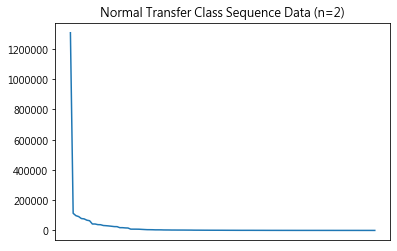

('2 2', '0 0', '2 1', '1 2', '0 2')
(1306868, 113112, 97566, 91575, 78536)
Gamma:  [-2.5428628]
A:  7.161390487631967
error: 0.22011766


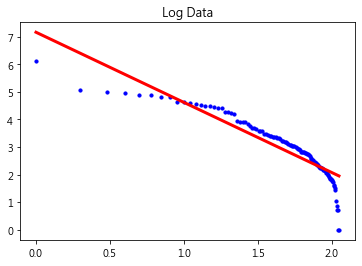

In [19]:
n = 2
dic_normal_transer = defaultdict(lambda: 0)
for d in x_transfer:
    #data = d.strip().split(' ')
    data = d
    #data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_normal_transer[index] = dic_normal_transer[index] + 1

lists = sorted(dic_normal_transer.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists) # unpack a list of pairs into two tuples
plt.title("Normal Transfer Class Sequence Data (n=2)")
plt.plot(px, py)
plt.xticks([]) #關閉X軸
plt.show()
print(px[:5])
print(py[:5])

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### transfer n = 3

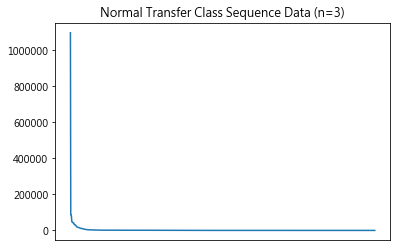

('2 2 2', '0 0 0', '2 2 1', '1 2 2', '2 0 2')
(1094263, 87091, 86693, 77086, 48551)
Gamma:  [-2.53464664]
A:  8.024380789803093
error: 0.10210715


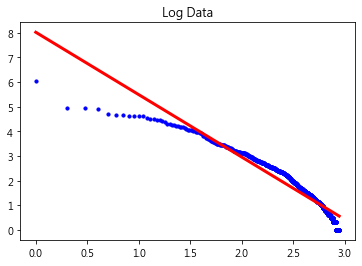

In [20]:
n = 3
dic_normal_transer = defaultdict(lambda: 0)
for d in x_transfer:
    #data = d.strip().split(' ')
    data = d
    #data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_normal_transer[index] = dic_normal_transer[index] + 1

lists = sorted(dic_normal_transer.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists) # unpack a list of pairs into two tuples
plt.title("Normal Transfer Class Sequence Data (n=3)")
plt.plot(px, py)
plt.xticks([]) #關閉X軸
plt.show()
print(px[:5])
print(py[:5])

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### transfer n = 5

In [ ]:
n = 5
dic_normal_transer = defaultdict(lambda: 0)
for d in x_transfer:
    #data = d.strip().split(' ')
    data = d
    #data = indent(data)
    for i in range(len(data) - n + 1):
        index = ' '.join(data[i:i+n])
        dic_normal_transer[index] = dic_normal_transer[index] + 1

lists = sorted(dic_normal_transer.items(), key=lambda kv: kv[1], reverse=True)
px, py = zip(*lists) # unpack a list of pairs into two tuples
plt.title("Normal Transfer Class Sequence Data (n=5)")
plt.plot(px, py)
plt.xticks([]) #關閉X軸
plt.show()
print(px[:5])
print(py[:5])

ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py)

### compute ratio

In [ ]:
multiple = 1
ratio1 = []
ratio2 = []

for query in xt_call_distribution[1:]:
    #if query[2] != 0 :
    
    #method 1 ratio1 = 佔整體比例
    if((query[2])/sum(query) != 1):
        pr = ((query[2])/sum(query)) * multiple
        ratio1.append(pr)
    
    #method 2 ratio2 = 兩類相除
    if query[2]!=0 :
        ratio2.append(query[1] / query[2])
    
ratio1 = np.sort(ratio1)[::-1]
ratio2 = np.sort(ratio2)[::-1]

#print(len(ratio))
print(ratio1[:10])

x_axis = get_increasing_array(len(ratio1)+1)
plt.plot(x_axis[1:], ratio1)
plt.show()

x_axis = get_increasing_array(len(ratio2)+1)
plt.plot(x_axis[1:], ratio2)
plt.show()




In [ ]:
print(ratio1[1])
print(sum(ratio1[:]))
print(sum(ratio1[:]) / len(ratio1))
print(len(ratio1))
test1 = np.zeros(1001)
test0 = np.zeros(1001)
for i in range(len(ratio1)):
    if ratio1[i] * 1000 > 1 : 
        test0[int(np.around(ratio1[i] * 1000))] += 1
        test1[int(np.around(abs(ratio1[i] * 1000 - 9)))] += 1
print(test1[:10])
print(sum(ratio2[:]))
print(sum(ratio2[:]) / len(ratio2))

In [ ]:
x_axis = get_increasing_array(len(test1))
print(test1[:10])
print(test1[1:5])
plt.plot(x_axis[:], test1[:])
plt.show()
ax = get_increasing_array(len(px)+1)
py = np.array(py)
log_and_fit(ax[1:],py+1)